In [1]:
# !pip uninstall torch torchvision torchaudio -y
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install mne -q
# !pip install wandb -q
# !pip install tensorboard -q

# Constants and libraries

In [2]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [3]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

from tqdm.auto import tqdm as tqdm_auto

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

import mne

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cuda


In [4]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils

from utils import SEED
from utils.models_evaluation import evaluateClassifier, evaluateRegressor, evaluateClassifier_inner_outer_cv
from utils.data_reading import DataReader
from utils.plotting import dataset_hists, plotData, dict_to_df
from utils.dataset import InMemoryDataset
from utils.logger import Logger
from utils.training import train_eval

from models.modules import encoder_conv, decoder_conv, encoder_conv4, decoder_conv4
from models.VAE import VAE, BetaVAE_H, BetaVAE_B
from models.AE import AE, AE_framework
from models.UNet import UNet

from training import train_eval

# Data load


### TUAB

In [5]:
# from sklearn.model_selection import train_test_split

# chunks_train = np.load(TUAB_TRAIN + "chunks_fz_cz_pz_3x124.npy").reshape(-1, 1, 3, 124)
# targets_train = np.load(TUAB_TRAIN + "targets.npy")
# chunks_val_test = np.load(TUAB_EVAL + "chunks_fz_cz_pz_3x124.npy").reshape(-1, 1, 3, 124)
# targets_val_test = np.load(TUAB_EVAL + "targets.npy")
# chunks_val, chunks_test, targets_val, targets_test = train_test_split(chunks_val_test, targets_val_test, test_size=0.5, random_state=SEED, shuffle=False)
# print(chunks_train.shape, targets_train.shape, chunks_val.shape, targets_val.shape, chunks_test.shape, targets_test.shape)

### Depression anonimyzed

In [6]:
file = DEPR_ANON_DIRECTORY + "dataset_128_10.0.pkl"
train_set, val_set, test_set = DataReader(file).split()
chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]


Chunks shape: (3, 1280) , length: 1068 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 178
Train=142, validation=18, test=18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:00<00:00, 31481.38it/s]

Train: 852 (3, 1280)
Validation: 108 (3, 1280)
Test: 108 (3, 1280)


### Inhouse dataset

In [7]:
# with open(INHOUSE_DIRECTORY + "dataset.pkl", "rb") as f:
#     chunks_list = pickle.load(f)
# print("\nChunks shape:", chunks_list[0]["chunk"].shape, "length:", len(chunks_list), "keys:", chunks_list[0].keys())

In [8]:
# from sklearn.model_selection import train_test_split
# from copy import deepcopy

# patients_targets = pd.DataFrame.from_records([{"patient": x["patient"], "target": x["target"]} for x in chunks_list]).drop_duplicates().reset_index(drop=True)
# print(f"N patients = {len(patients_targets)}")

# patients_train, patients_val_test = train_test_split(patients_targets, test_size=0.2, random_state=SEED, stratify=patients_targets["target"], shuffle=True)
# patients_val, patients_test = train_test_split(patients_val_test, test_size=0.5, random_state=SEED, stratify=patients_val_test["target"], shuffle=True)
# patients_train, patients_val, patients_test = patients_train["patient"].values, patients_val["patient"].values, patients_test["patient"].values
# print(f"Train={len(patients_train)}, validation={len(patients_val)}, test={len(patients_test)}")

# reset = {"chunk": [], "target": [], "patient": []}
# train_set, val_set, test_set = deepcopy(reset), deepcopy(reset), deepcopy(reset)

# for chunk in tqdm_auto(chunks_list):
#     patient_id = chunk["patient"]
#     was_added = False
#     for data_set, patients in zip([train_set, val_set, test_set], [patients_train, patients_val, patients_test]):
#         if patient_id in patients:
#             for tag in ["chunk", "target", "patient"]:
#                 data_set[tag].append(chunk[tag])
#                 was_added = True
        
#     if not was_added:
#         raise ValueError(f"Unexpected patient id {patient_id}")
    
# for data_set in [train_set, val_set, test_set]:
#     data_set["chunk"] = np.array(data_set["chunk"])
#     data_set["target"] = np.array(data_set["target"])

# print("Train:", len(train_set["chunk"]), train_set["chunk"][0].shape)
# print("Valitation:", len(val_set["chunk"]), val_set["chunk"][0].shape)
# print("Test:", len(test_set["chunk"]), test_set["chunk"][0].shape)

In [9]:
# chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
# targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]

#### For training on healthy only

In [10]:
# chunks_train_0 = chunks_train[np.where(targets_train == 0)]
# targets_train_0 = np.zeros(len(chunks_train_0))

# chunks_train = chunks_train_0
# targets_train = targets_train_0

# Data exploration

### TUAB

#### Targets

In [11]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
# ax[0].hist(targets_train);
# ax[0].set_title("Train");
# ax[1].hist(targets_val);
# ax[1].set_title("Validation");
# ax[2].hist(targets_test);
# ax[2].set_title("Test");
# plt.show();

#### Chunks

In [12]:
# for chunks in [chunks_train, chunks_val, chunks_test]:
#     chunks_minmax = []
#     for sample in chunks:
#         chunks_minmax.append((sample - sample.min())/(sample.max() - sample.min()))

#     print("Mean", np.array(chunks_minmax).mean(), "std", np.array(chunks_minmax).std())

In [13]:
# for chunks in [chunks_train, chunks_val, chunks_test]:
#     fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 2))
#     for i, ch in enumerate(np.moveaxis(chunks_train, [0, 1, 2, 3], [2, 1, 0, 3]).reshape([3, -1])):
#         ax[i].hist(ch, bins=50, range=[-5, 5])

### Depression anonymized

In [14]:
# dataset_hists(train_set, val_set, test_set)

### Inhouse dataset

In [15]:
# for data_set in [train_set, val_set, test_set]:
#     fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 2))
#     for i in range(3): ax[i].hist(data_set["chunk"][:, i, :].flatten(), bins=20, range=(-5,5))
#     ax[3].hist(data_set["target"], bins=3)
#     plt.show()

# Train by hands

In [16]:
data_config = {
    "batch_size": 256,
    "num_workers": 0,
    "samples_shape": chunks_train[0].shape,
    "n_train_samples": len(chunks_train),
    "n_validation_samples": len(chunks_val),
    "n_test_samples": len(chunks_test),
    "minmax": "across_whole_sample",
    "record_part": "10 s",
    "task": "MDD classification",
    "dataset": "depression anonymized" #!!! CHECK BEFORE TRAINING
}

## Dataset preparation

Train dataset: 852
Val dataset: 108
Test dataset: 108
Train dataloader: 4
Val dataloader: 1
Test dataloader: 1
Train sample shape: torch.Size([3, 1280])
Val sample shape: torch.Size([3, 1280])
Test sample shape: torch.Size([3, 1280])
Train sample type: torch.FloatTensor
Val sample type: torch.FloatTensor
Test sample type: torch.FloatTensor


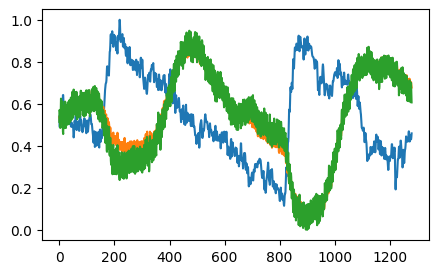

In [17]:
t_max=None
train_dataset = InMemoryDataset(chunks_train, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
val_dataset = InMemoryDataset(chunks_val, is_squeeze=False, is_unsqueeze=False, t_max=t_max)
test_dataset = InMemoryDataset(chunks_test, is_squeeze=False, is_unsqueeze=False, t_max=t_max)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=data_config['batch_size'], num_workers=data_config['num_workers'])

print("Train dataset:", len(train_dataset))
print("Val dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

print("Train dataloader:", len(train_dataloader))
print("Val dataloader:", len(val_dataloader))
print("Test dataloader:", len(test_dataloader))

print("Train sample shape:", train_dataset[0].shape)
print("Val sample shape:", val_dataset[0].shape)
print("Test sample shape:", test_dataset[0].shape)

print("Train sample type:", train_dataset[0].type())
print("Val sample type:", val_dataset[0].type())
print("Test sample type:", test_dataset[0].type())

plt.figure(figsize=(5,3))
plt.plot(train_dataset[0].squeeze().T)
plt.show()

## Training

### Train/validation function

### train

In [19]:
## models #######################################################################

###################
## shallow networks
###################

# model_description="beta-VAE, 3 ch., 32/32, 6/6, PReLU"
# model_config = {
#     "latent_dim": 10,
#     "beta": 2,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "latent_multiplier" : 2
# }
# model = VAE(
#     encoder_conv(model_config),
#     decoder_conv(model_config),
#     **model_config
# ).to(device)

# model_description="0 train, inhouse, beta-VAE-B, 3 ch., 32/32, 6/6, PReLU"
# model_config = {
#     "latent_dim": 10,
#     "beta": 100,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "C_max": 100,
#     "C_stop_iter": len(train_dataloader)*50,
#     "device": device,
#     "latent_multiplier" : 2
# }
# model = BetaVAE_B(
#     encoder_conv(model_config),
#     decoder_conv(model_config),
#     **model_config
# ).to(device)

# model_description="inhouse, beta-VAE-H, 3 ch., 32/32, 6/6, PReLU"
# model_config = {
#     "latent_dim": 10,
#     "beta": 2,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "latent_multiplier" : 2
# }
# model = BetaVAE_H(
#     encoder_conv(model_config),
#     decoder_conv(model_config),
#     **model_config
# ).to(device)

# model_description="AE, 3 ch., 32/32, 6/6, PReLU"
# model_config = {
#     "latent_dim": 10,
#     "input_dim": train_dataset[0].shape,
#     "latent_multiplier": 1
# }
# model = AE_framework(
#     encoder_conv(model_config),
#     decoder_conv(model_config),
#     **model_config
# ).to(device)

################
## deep networks
################

# model_description="depr. anon., beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid" #!!! CHECK BEFORE TRAINING
# model_config = {
#     "latent_dim": 15*32,
#     "beta": 2,
#     "input_dim": train_dataset[0].shape,
#     "latent_std": 1,
#     "n_channels": 3,
#     "n_classes": 3,
#     "first_decoder_conv_depth": 32
# }
# model = VAE(
#     encoder_conv4(model_config["n_channels"]),
#     decoder_conv4(model_config["n_classes"]),
#     **model_config
# ).to(device)

model_description="depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid"
model_config = {
    "input_dim": train_dataset[0].shape,
}
model = AE(
    n_channels=train_dataset[0].shape[-2],
    n_classes=train_dataset[0].shape[-2]
).to(device)

# model_description="UNet, 3 ch., 3/3/2/1, 7/7/5/3/3/3/3/1, PReLU"
# model_config = {
#     "input_dim": train_dataset[0].shape,
#     "c1": 3,
#     "c2": 3,
#     "c3": 2,
#     "c_neck": 1
# }
# model = UNet(
#     n_channels=train_dataset[0].shape[-2],
#     n_classes=train_dataset[0].shape[-2],
#     c1=model_config["c1"],
#     c2=model_config["c2"],
#     c3=model_config["c3"],
#     c_neck=model_config["c_neck"],
# ).to(device)

##################################################################################

## download weights ##############################################################

# run = wandb.init()
# artifact = run.use_artifact('dmitriykornilov_team/EEG_age_prediction/VAE:v13', type='model')
# artifact_dir = artifact.download()
# model.load_state_dict(torch.load(artifact_dir + '/50_epoch.pth'))
# wandb.finish()

##################################################################################

print(f'model {model_description} is created')

# Let's check that forward works
model.eval()
print("Test data point shape:", train_dataset[0][None].shape)
print("Test inference:", len(model(train_dataset[0][None].to(device))))
print("Test reconstruct:", model.reconstruct(train_dataset[0][None].to(device)).shape)
print("Test encode:", model.encode(train_dataset[0][None].to(device)).shape)

model depr. anon., AE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid is created
Test data point shape: torch.Size([1, 3, 1280])
Test inference: 1
Test reconstruct: torch.Size([1, 3, 1280])
Test encode: torch.Size([1, 32, 160])


In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) # instantiate optimizer
print('optimzer created')

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
print("scheduler created")

optimzer created
scheduler created


In [26]:
def objectName(object):
    return str(type(object)).split(".")[-1].replace("\'>", "")

train_config = {
    "model": objectName(model),
    "model_config": model_config,

    "optimizer": objectName(optimizer),
    "optimizer_config": optimizer.defaults,

    "scheduler": objectName(scheduler),
    "scheduler_config": {
        "factor": scheduler.factor,
        "min_lr": scheduler.min_lrs[0],
        "patience": scheduler.patience,
        "cooldown": scheduler.cooldown,
        "mode": scheduler.mode,
        "threshold": scheduler.threshold,
        "threshold_mode": scheduler.threshold_mode,
        "eps": scheduler.eps
    },
    
    "loss_coefs": {
        "ampl": 1,
        "vel": 0,
        "acc": 0,
        "frq": 0,
        "kl": 1
    },
    "masking" :{
        "n_masks" : 0,
        "mask_ratio" : 0
    },
    
    "start_epoch": 0, # including #!!!CHECK BEFORE TRAINING
    "end_epoch": 50, # excluding #!!!CHECK BEFORE TRAINING,

    "avg_embeddings_over_time": True,
}

ml_config = {
    "ml_model" : Pipeline([('scaler', StandardScaler()), ('clf', SVC())]),
    "ml_param_grid" : {
        'clf__kernel': ['linear'],
        'clf__C': np.logspace(-1, 1, 3),
        'clf__probability': [True],
        'clf__class_weight': ['balanced'],
        'clf__random_state': [SEED]
    },
    "ml_eval_function" : [evaluateClassifier, evaluateClassifier_inner_outer_cv],
    "ml_eval_function_tag" : ["d", "cv"],
    "ml_eval_function_kwargs" : [
        {
            "verbose" : 1,
            "test_size" : 0.33,
            "SEED" : SEED,
            "cv_scorer" : accuracy_score,
            "metrics" : [(average_precision_score, "soft"), (roc_auc_score, "soft"), (accuracy_score, "hard"), (f1_score, "hard")],
            "metrics_for_CI" : [(average_precision_score, "soft"), (roc_auc_score, "soft"), (accuracy_score, "hard"), (f1_score, "hard")],
            "n_bootstraps" : 1000
        },
        {
            "verbose" : 1,
            "SEED" : SEED,
            "cv_scorer" : accuracy_score,
            "metrics" : [(average_precision_score, "soft"), (roc_auc_score, "soft"), (accuracy_score, "hard"), (f1_score, "hard")],
            "n_splits" : 10,
        }
    ],
    "ml_metric_prefix" : "clf",
    
    # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
    # ml_param_grid={
    #     'reg__alpha': np.logspace(-2, 2, 5),
    #     # 'reg__solver': ['sag'],
    #     # 'reg__tol': [1e-4]
    # },
    # ml_eval_function=evaluateRegressor,
    # ml_metric_names=["mse_test", "mse_train"],
    # ml_metric_prefix="reg",
}

project_name = 'EEG_age_prediction'
save_path = OUTPUT_FOLDER + 'models/'
config = {**train_config, **data_config, "method": "direct restoration", "save path": save_path}
print("Config:", json.dumps(config, indent=4))

Config: {
    "model": "AE",
    "model_config": {
        "input_dim": [
            3,
            1280
        ]
    },
    "optimizer": "AdamW",
    "optimizer_config": {
        "lr": 0.001,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.01,
        "amsgrad": false,
        "foreach": null,
        "maximize": false,
        "capturable": false,
        "differentiable": false,
        "fused": null
    },
    "scheduler": "ReduceLROnPlateau",
    "scheduler_config": {
        "factor": 0.5,
        "min_lr": 0,
        "patience": 3,
        "cooldown": 0,
        "mode": "min",
        "threshold": 0.0001,
        "threshold_mode": "rel",
        "eps": 1e-08
    },
    "loss_coefs": {
        "ampl": 1,
        "vel": 0,
        "acc": 0,
        "frq": 0,
        "kl": 1
    },
    "masking": {
        "n_masks": 0,
        "mask_ratio": 0
    },
    "start_epoch": 0,
    "end_epoch": 50,
    "avg_embeddings_ov

Logging via WandB


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dmitriykornilov (dmitriykornilov_team). Use `wandb login --relogin` to force relogin


  0%|                                                                                                                                   | 0/50 [00:00<?, ?it/s]

##### Training... #####
Model is in train mode


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,lr
0,1141.000,0.703,0.512,-0.425,1141.000,12.134,10.737,5.297,0.001


##### Validation... #####
Model is in evaluation mode
Epoch 0, step 0
Plotting PCA...


,Explained variance,Ratio
0,4.075995e-12,0.979048
1,4.645575e-14,0.011159


Plotting reconstruction...


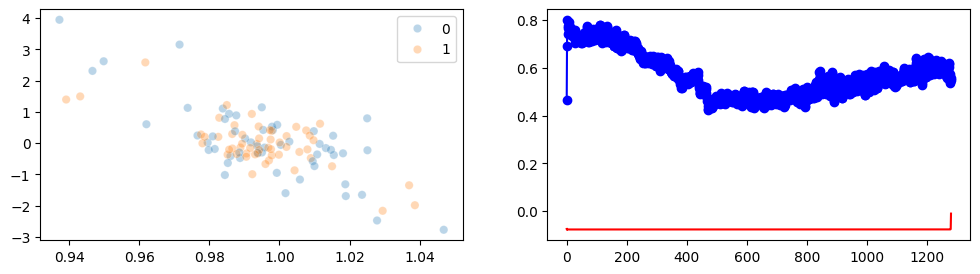

Classifier/regressor metrics evaluation...
Data split
GridSearchCV
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Evaluation on the train data
Evaluation on the test data


In [ ]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

logger = Logger(
    log_type="wandb", #"wandb"/"tensorboard"/"none" #!!!CHECK BEFORE TRAINING
    run_name=model_description,
    save_path=save_path,
    model=model,
    model_name=config["model"],        
    project_name=project_name,
    config=config,
    model_description=model_description,
#         log_dir = OUTPUT_FOLDER + "logs/"
)

#training
# best_loss = np.inf
best_clf_accuracy = -np.inf
best_model = None
best_epoch = None
final_model = None

for epoch in tqdm_auto(range(config['start_epoch'], config['end_epoch'])):
    #######
    # train
    #######
    print("##### Training... #####")
    model, results = train_eval(
        train_dataloader,
        model,
        device=device,
        mode="train",
        optimizer=optimizer,
        epoch=epoch,
        logger=logger,
        loss_coefs=train_config["loss_coefs"],
        is_mask=False,
        mask_ratio=config["masking"]["mask_ratio"],
        # step_max=1, #!!!CHECK BEFORE TRAINING
    )
    if results == {}: break
    display(dict_to_df(results))

    ############
    # validation
    ############
    print("##### Validation... #####")
    model, results = train_eval(
        test_dataloader,
        model,
        device=device,
        mode="validation",
        test_dataset=test_dataset,
        targets_test=targets_test,
        check_period=1e10,
        plot_period=1e10,
        epoch=epoch,
        logger=logger,
        loss_coefs=train_config["loss_coefs"],
        is_mask=False,
        mask_ratio=config["masking"]["mask_ratio"],
        avg_embeddings_over_time=train_config["avg_embeddings_over_time"],
        plot_type="classification", #"regression"/"classification"
        **ml_config,
        # step_max=1, #!!!CHECK BEFORE TRAINING
    )
    if results == {}: break
    display(dict_to_df(results))

    scheduler.step(results['loss'])
    logger.save_model(epoch)
    final_model = model

    if results['clf.cv.test.accuracy.cv'] >= best_clf_accuracy:
        best_clf_accuracy = results['clf.cv.test.accuracy.cv']
        best_model = model
        best_epoch = best_epoch
        print(f"New best classifier accuracy = {best_clf_accuracy} on epoch {epoch}")
    
    # if results['loss'] < best_loss:
    #     best_loss = results['loss']
    #     best_model = model
    #     best_epoch = best_epoch
    #     print(f"New best loss = {best_loss} on epoch {epoch}")

logger.save_model(config['end_epoch'])

######
# test
######
for model, mode in zip([final_model, best_model], ["final", "test"]):
    print(f"##### Testing in {mode} mode... #####")
    _, results = train_eval(
        val_dataloader,
        model,
        device=device,
        mode=mode,
        test_dataset=val_dataset,
        targets_test=targets_val,
        check_period=1e10,
        plot_period=1e10,
        epoch=config['end_epoch'],
        logger=logger,
        avg_embeddings_over_time=train_config["avg_embeddings_over_time"],
        plot_type="classification", #"regression"/"classification",
        **ml_config,
        # step_max=1,
    )
    display(dict_to_df(results))

logger.update_summary("validation.best_epoch", best_epoch)
logger.finish()